In [2]:
import sys
sys.path.append('..')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from sentiment import sentiment_vader
from imdb_api.imdbscraper import ImdbScraper

### Trailers

In [4]:
file_list = ['hbo', 'amazon', 'netflix', 'disney']
dfs = []
for file in file_list:
    df = pd.read_csv('../data/' + file + '.csv')
    df['network'] = file
    dfs.append(df)

trailers = pd.concat(dfs)

### Comments and sentiment

In [5]:
file_list = ['hbo_comments', 'amazon_comments', 'netflix_comments']
dfs = []
for file in file_list:
    df = pd.read_csv('../comments/' + file + '.csv')
    dfs.append(df)

comments = pd.concat(dfs)

In [89]:
comments['sentiment_raw'] = comments.textOriginal.astype(str).apply(sentiment_vader)

In [91]:
sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
comments['sentiment_score'] = comments.sentiment_raw.str[-1].map(sentiment_map)
comments_agg = comments.groupby('videoId').agg(
    num_comments=('commentId', 'count'),
    sentiment_agg=('sentiment_score', 'mean')
).reset_index()

### Mapping imdb and youtube

In [6]:
file_list = ['hbo', 'amazon', 'netflix']
dfs = []
for file in file_list:
    df = pd.read_csv('../data/match/' + file + '_match.csv', delimiter=';')
    dfs.append(df)

match = pd.concat(dfs).dropna()

### IMDb

In [7]:
imdb = pd.read_csv('../imdb/title.basics.tsv', delimiter='\t')
ratings = pd.read_csv('../imdb/title.ratings.tsv', delimiter='\t')
imdb = imdb.merge(ratings, on='tconst')

C:\Users\marcu\AppData\Local\Temp/ipykernel_8560/3867179827.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb = pd.read_csv('../imdb/title.basics.tsv', delimiter='\t')


### IMDb release dates

In [45]:
# scraper = ImdbScraper()
# scraper.scrape_dates(match.tconst, verbose=True, timeout=1)

In [9]:
# release_dates = pd.DataFrame(scraper.data)
# release_dates['dt'] = pd.to_datetime(release_dates.release_date_us)

In [11]:
release_dates = pd.read_csv('../data/release_dates/release_dates.csv')

### Annotations

In [16]:
annot = pd.read_csv('../comments/annotated.csv')

### The big join

In [18]:
df = trailers.merge(comments, on='videoId')
df = df.merge(match, on='videoId')
df = df.merge(imdb, on='tconst')
df = df.merge(release_dates, left_on='tconst', right_on='id')
df = df.merge(annot, on='commentId', how='left')

C:\Users\marcu\AppData\Local\Temp/ipykernel_8560/4155978374.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = df.merge(annot, on='commentId', how='left')


In [23]:
list(df)

['Unnamed: 0_x',
 'channelId',
 'videoId_x',
 'videoTitle',
 'publishTime',
 'publishedAt_x',
 'title_lowered',
 'is_trailer',
 'network',
 'Unnamed: 0_y',
 'commentId',
 'textOriginal_x',
 'likeCount_x',
 'publishedAt_y',
 'tconst',
 'titleType',
 'primaryTitle',
 'originalTitle',
 'isAdult',
 'startYear',
 'endYear',
 'runtimeMinutes',
 'genres',
 'averageRating',
 'numVotes',
 'Unnamed: 0_x',
 'id_x',
 'release_date_us',
 'Unnamed: 0_y',
 'videoId_y',
 'textOriginal_y',
 'likeCount_y',
 'publishedAt',
 'id_y',
 'sentiment',
 'annotator',
 'annotation_id',
 'created_at',
 'updated_at',
 'lead_time']

In [44]:
df = df[df.videoId_x == 'DotnJ7tTA34']
df['dt'] = pd.to_datetime(df.publishedAt_y)

In [55]:
df['date'] = df.dt.dt.date

In [63]:
agg = df.groupby('date').agg(asdf=('commentId', 'count')).reset_index()

In [67]:
agg = agg.sort_values('date')

In [89]:
release = pd.to_datetime(df.release_date_us.unique()[0])

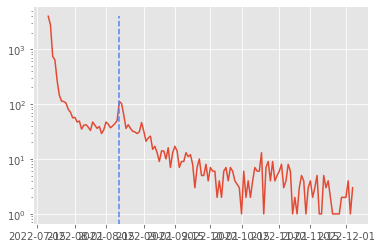

In [105]:
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.plot(agg.date, agg.asdf)
ax.set_yscale('log')
ax.vlines(release, 0, agg.asdf.max(), color='#5184FA', linestyle='--')